In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pytorch_lightning as pl

from torch_geometric.data import DataLoader
import pytorch_lightning as pl
import os.path as osp

from tqdm import tqdm

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import configuration
import model_registry
import data.build
import data.constants as dconst
from data.util import data_get_num_attributes, data_get_num_classes
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification, Ensemble
from evaluation.util import get_data_loader, run_model_on_datasets, separate_distributions
import evaluation.callbacks as ecbs
from metrics import expected_calibration_error
from plot.calibration import plot_calibration
from data.util import label_binarize
from model.density import get_density_model
import seed
from train import train_model
from model.build import make_model

In [4]:
import logging as l

l.basicConfig(level=l.INFO)

In [5]:
dataset = dconst.AMAZON_PHOTO

spectral_norm_conf = {'model' : {
        'use_spectral_norm' : True,
        'residual' : True,
        'weight_scale' : 200.0,
    },}

config = configuration.ExperimentConfiguration(
    data={
        'dataset' : dataset,
        'setting' : dconst.HYBRID,
        'ood_type' : dconst.PERTURBATION,
        'use_dataset_registry' : False,
    },
    # **spectral_norm_conf,
    run = {
        'use_default_configuration' : True,
    },
)
config_norm = configuration.ExperimentConfiguration(
    data={
        'dataset' : dataset,
        'setting' : dconst.HYBRID,
        'ood_type' : dconst.PERTURBATION,
        'use_dataset_registry' : False,
    },
    **spectral_norm_conf,
    run = {
        'use_default_configuration' : True,
    },
)
if config.run.use_default_configuration:
    configuration.update_with_default_configuration(config)
    configuration.update_with_default_configuration(config_norm)
    
print(config.run.use_default_configuration)

INFO:root:Set configuration value data.base_labels to default all
INFO:root:Set configuration value data.corpus_labels to default all
INFO:root:Set configuration value data.train_labels to default all
INFO:root:Set configuration value data.left_out_class_labels to default ['Film Photography', 'Binoculars & Scopes', 'Video Surveillance']
INFO:root:Set configuration value data.preprocessing to default none
INFO:root:Set configuration value data.ood_sampling_strategy to default all
INFO:root:Set configuration value data.train_portion to default 20
INFO:root:Set configuration value data.test_portion_fixed to default 0.2
INFO:root:Set configuration value data.split_type to default uniform
INFO:root:Set configuration value data.type to default npz
INFO:root:Set configuration value data.drop_train_vertices_portion to default 0.1
INFO:root:Set configuration value data.precompute_k_hop_neighbourhood to default 2
INFO:root:Set configuration value model.hidden_sizes to default [64]
INFO:root:Set 

True


In [6]:
config.data.setting

'hybrid'

In [7]:
config.model.use_bias = True
config_norm.model.use_bias = True

In [8]:
data_split_seed = seed.data_split_seeds()[config.run.split_idx]
config.registry.split_seed = data_split_seed
model_seed_generator = iter(seed.SeedIterator(seed.model_seeds()[config.run.initialization_idx]))
data_dict, fixed_vertices = data.build.load_data_from_configuration(config.data, data_split_seed)
data_loaders = {
    name : DataLoader(data, batch_size=1, shuffle=False) for name, data in data_dict.items()
}

INFO:root:Did not find precomputed dataset split.
INFO:root:Data Loading - Loaded adjacency matrix.
INFO:root:Data Loading - Did not find vertex names in amazon_photo. Generating default names...
INFO:root:Data Loading - Built attribute matrix.


Build SingleGraphDataset with additional attribute dict_keys(['feature_to_idx'])
Build SingleGraphDataset with additional attribute dict_keys(['feature_to_idx'])


INFO:root:Precompute <= 2 neighbourhoods of ood graph.


Build SingleGraphDataset with additional attribute dict_keys(['feature_to_idx'])
Build SingleGraphDataset with additional attribute dict_keys(['feature_to_idx'])
Build SingleGraphDataset with additional attribute dict_keys(['feature_to_idx'])
Build SingleGraphDataset with additional attribute dict_keys(['is_train_graph_vertex', 'feature_to_idx', '0_hop_neighbourhood_indptr', '0_hop_neighbourhood_indices', '1_hop_neighbourhood_indptr', '1_hop_neighbourhood_indices', '2_hop_neighbourhood_indptr', '2_hop_neighbourhood_indices'])
Build SingleGraphDataset with additional attribute dict_keys(['is_train_graph_vertex', 'feature_to_idx', '0_hop_neighbourhood_indptr', '0_hop_neighbourhood_indices', '1_hop_neighbourhood_indptr', '1_hop_neighbourhood_indices', '2_hop_neighbourhood_indptr', '2_hop_neighbourhood_indices'])


/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
for batch in data_loaders[dconst.TRAIN]:
    print()

In [10]:
_ = data_dict[dconst.TRAIN][0].feature_to_idx

In [11]:
(data_dict[dconst.TRAIN][0].x > 0).float().mean(1).mean(0)

tensor(0.3486)

In [12]:
model_seed = next(model_seed_generator)

In [13]:
run_artifact_dir = artifact_dir = osp.join(config.logging.artifact_dir, 'spectral-structure')

In [14]:
config.run.use_pretrained_model = False # We need to re-train the models
config_norm.run.use_pretrained_model = False # We need to re-train the models

In [15]:
if not torch.cuda.is_available():
    config.training.gpus = 0
    config_norm.training.gpus = 0
config.training.gpus, config_norm.training.gpus

(0, 0)

In [16]:
# Create a callback that logs the weight matrix svd
from collections import defaultdict

class LogWeightMatrixSpectrum(pl.callbacks.Callback):
    """ Finds all weight matrices and logs their spectrum every epoch. """

    def __init__(self, log_every_epoch=1):
        super().__init__()
        self.log_every_epoch = log_every_epoch
        self._buffer = defaultdict(list)
        self._epoch_buffer = []

    def on_validation_epoch_start(self, trainer: pl.Trainer, model: pl.LightningModule):
        if trainer.global_step % self.log_every_epoch == 0:
            self._epoch_buffer.append(trainer.global_step)
            weights = model.get_weights()
            for name, weight in weights.items():
                u, s, v = np.linalg.svd(weight.detach().cpu().numpy(), full_matrices=False)
                self._buffer[name].append((u, s, v))

In [17]:
svd_callback = LogWeightMatrixSpectrum()

In [18]:
svd_callback_norm = LogWeightMatrixSpectrum()

In [19]:
config.registry.model_seed = model_seed
pl.seed_everything(model_seed)
model = make_model(config, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0]))
print(model)
model = train_model(model, config, artifact_dir, data_loaders, logger=None, callbacks=[svd_callback]).eval()

Global seed set to 1952926171
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Starting model training.

  | Name     | Type | Params
----------------------------------
0 | backbone | GCN  | 48.3 K
----------------------------------
48.3 K    Trainable params
0         Non-trainable params
48.3 K    Total params
0.193     Total estimated model params size (MB)


SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=745, out_features=64, bias=True)
          )
        (act): LeakyReLU(negative_slope=0.01)
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=64, out_features=8, bias=True)
          )
      )
    )
  )
)


Global seed set to 1952926171
INFO:root:Paths ['/nfs/students/fuchsgru/model_registry/-7904550698936965973-1650715092-0778632-1887091165.ckpt'] were overwritten with /nfs/students/fuchsgru/model_registry/-6905525589867655496-1650730082-9574614-2003114875.ckpt (copied from /nfs/students/fuchsgru/artifacts/spectral-structure/epoch=999-step=999.ckpt).
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/-6905525589867655496-1650730082-9574614-2003114875.ckpt.


In [20]:
config_norm.registry.model_seed = model_seed
pl.seed_everything(model_seed)
model_norm = make_model(config_norm, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0]))
print(model_norm)
model = train_model(model_norm, config, artifact_dir, data_loaders, logger=None, callbacks=[svd_callback_norm]).eval()

Global seed set to 1952926171
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Starting model training.

  | Name     | Type | Params
----------------------------------
0 | backbone | GCN  | 96.1 K
----------------------------------
96.1 K    Trainable params
0         Non-trainable params
96.1 K    Total params
0.384     Total estimated model params size (MB)


SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): ResidualBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): ParametrizedLinear(
              in_features=745, out_features=64, bias=True
              (parametrizations): ModuleDict(
                (weight): ParametrizationList(
                  (0): SpectralNorm(rescaling=200.0, n_iter=1)
                )
              )
            )
          )
        (act): LeakyReLU(negative_slope=0.01)
        (input_projection): LinearWithParametrization(
          (linear): ParametrizedLinear(
            in_features=745, out_features=64, bias=True
            (parametrizations): ModuleDict(
              (weight): ParametrizationList(
                (0): SpectralNorm(rescaling=200.0, n_iter=1)
              )
            )
          )
        )
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear

Global seed set to 1952926171
INFO:root:Paths ['/nfs/students/fuchsgru/model_registry/-6905525589867655496-1650730082-9574614-2003114875.ckpt'] were overwritten with /nfs/students/fuchsgru/model_registry/-6905525589867655496-1650730879-2264602-2003114875.ckpt (copied from /nfs/students/fuchsgru/artifacts/spectral-structure/epoch=439-step=439.ckpt).
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/-6905525589867655496-1650730879-2264602-2003114875.ckpt.


In [21]:
svd_callback._buffer.keys(), svd_callback_norm._buffer.keys()

(dict_keys(['backbone.conv0.lin.weight', 'backbone.conv1.lin.weight']),
 dict_keys(['backbone.conv0.lin.weight', 'backbone.conv0.residual_projection.weight', 'backbone.conv1.lin.weight']))

In [22]:
svs = {
    k : np.array([s for u, s, v in buf]) for k, buf in svd_callback._buffer.items()
}
svs_norm = {
    k : np.array([s for u, s, v in buf]) for k, buf in svd_callback_norm._buffer.items()
}

In [23]:
svd_callback_norm._epoch_buffer[-25:]

[419,
 420,
 421,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 442,
 443]

In [24]:
svs.keys(), svs_norm.keys()

(dict_keys(['backbone.conv0.lin.weight', 'backbone.conv1.lin.weight']),
 dict_keys(['backbone.conv0.lin.weight', 'backbone.conv0.residual_projection.weight', 'backbone.conv1.lin.weight']))

In [25]:
from typing import Tuple, Any, Optional
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def plot_histogram_evolution(values: np.ndarray, num_bins: int = 25, figsize: Tuple[float, float]=(10, 5), value_name: Optional[str]=None,
        time_name: Optional[str]='Epoch', time_interval: int=1) -> Tuple[plt.Figure, Any]:
    """ Plots the evolution of a 1d distribution as a 2d heatmap with time on the x axis.
    
    Parameters:
    -----------
    values : ndarray, shape [sequence_length, num_observations]
        The observations to plot the distribution of.
    num_bins : int, optional, default: 25
        How many bins to use for the observations.
    figsize : Tuple[float, float], optional, default: (10, 5)
        The size of the plt figure.
    value_name : str, optional, default: None
        If given, what the observations are called.
    time_name : str, optional, default: 'Epoch'
        If given, what the temporal axis should be labeled with.
    time_interval : int, optional, default: 1
        The step in which the temporal x axis goes.
    
    Returns:
    --------
    fig : plt.Figure
        The figure.
    ax : plt.axes.Axes
        The axis.
    """ 
    bin_centers = np.linspace(np.round(values.min() - 0.5, 0), np.round(values.max() + 0.5, 0), num_bins)

    distances = np.abs(values.flatten()[:, None] - bin_centers[None, :])
    bin_idxs = distances.argmin(1).reshape(values.shape)

    counts = np.zeros((num_bins, values.shape[0]))
    for epoch in range(values.shape[0]):
        for bin_idx in bin_idxs[epoch]:
            counts[bin_idx, epoch] += 1

    counts = pd.DataFrame(counts, index=np.round(bin_centers, 2), columns=[i * time_interval for i in range(values.shape[0])])
    if value_name:
        counts.index.name = value_name
    if time_name:
        counts.columns.name = time_name

    fig, ax = plt.subplots(figsize=figsize)
    
    viridis = cm.get_cmap('viridis', 256)
    newcolors = viridis(np.linspace(0, 1, 256))
    newcolors[:1, :] = [1, 1, 1, 1]
    newcmp = ListedColormap(newcolors)
    
    sns.heatmap(counts, robust=True, ax=ax, cmap=newcmp, cbar_kws={'label' : 'Count'})
    return fig, ax


In [26]:
def counts(values, num_bins=25):
    bin_centers = np.linspace(np.round(values.min() - 0.5, 0), np.round(values.max() + 0.5, 0), num_bins)

    distances = np.abs(values.flatten()[:, None] - bin_centers[None, :])
    bin_idxs = distances.argmin(1).reshape(values.shape)

    counts = np.zeros((num_bins, values.shape[0]))
    for epoch in range(values.shape[0]):
        for bin_idx in bin_idxs[epoch]:
            counts[bin_idx, epoch] += 1

    counts = pd.DataFrame(counts, index=np.round(bin_centers, 2), columns=[i for i in range(values.shape[0])])
    return counts
    

In [27]:
def plot_heatmap2d(ax: Any, values: np.ndarray, figsize: Tuple[float, float]=(10, 5), value_name: Optional[str]=None,
        time_name: Optional[str]='Epoch', time_interval: int=1, log_scale: bool=True, cbar_label: Optional[str]=None) -> Tuple[plt.Figure, Any]:
    """ Plots a 2d heatmap.
    
    Parameters:
    -----------
    values : ndarray, shape [sequence_length, num_observations]
        The observations to plot the distribution of.
    figsize : Tuple[float, float], optional, default: (10, 5)
        The size of the plt figure.
    value_name : str, optional, default: None
        If given, what the observations are called.
    time_name : str, optional, default: 'Epoch'
        If given, what the temporal axis should be labeled with.
    time_interval : int, optional, default: 1
        The step in which the temporal x axis goes.
    
    Returns:
    --------
    fig : plt.Figure
        The figure.
    ax : plt.axes.Axes
        The axis.
    """ 
    if log_scale:
        values = np.log(values)
        if cbar_label:
            cbar_label = f'Log {cbar_label}'
    df = pd.DataFrame(values.T, columns=time_interval * np.arange(values.shape[0]))
    if value_name:
        df.index.name = value_name
    if time_name:
        df.columns.name = time_name
    if cbar_label:
        cbar_kwargs = {
            'label' : cbar_label
        }
    else:
        cbar_kwargs = {}
    sns.heatmap(df, ax=ax, cbar_kws=cbar_kwargs, cmap='viridis')
    return fig, ax

In [28]:
def despine(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

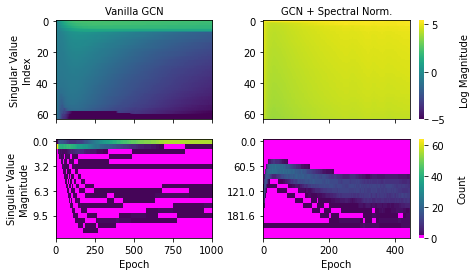

In [29]:
eps = 0.08
fig, axs = plt.subplots(2, 2, sharey=False, sharex='col', figsize=(7, 4),
    gridspec_kw = {'width_ratios' : [1.0 - eps, 1.0 + eps], 'wspace' : 0.3}
                       )

# Upper row, individual values
log_svs = np.log(svs['backbone.conv0.lin.weight'])
log_svs_norm = np.log(svs_norm['backbone.conv0.lin.weight'])

vmin, vmax = max(-5, min(log_svs.min(), log_svs_norm.min())), max(log_svs.max(), log_svs_norm.max())

axs[0, 0].imshow(log_svs[:-1].T, cmap='viridis', vmin=vmin, vmax=vmax, aspect='auto', interpolation='none')
#despine(axs[0, 0])
im = axs[0, 1].imshow(log_svs_norm[:-1].T, cmap='viridis', vmin=vmin, vmax=vmax, aspect='auto', interpolation='none')
#despine(axs[0, 1])
cbar = fig.colorbar(im, ax=axs[0, 1], drawedges=False)
cbar.set_label('Log Magnitude', labelpad=14)
cbar.outline.set_visible(False)
cbar.solids.set_edgecolor("face")

#sns.heatmap(log_svs.T, ax=axs[0, 0], cmap='viridis', vmin=vmin, vmax=vmax, cbar=False, linewidths=0)
#sns.heatmap(log_svs_norm.T, ax=axs[0, 1], cmap='viridis', vmin=vmin, vmax=vmax, cbar_kws={'label' : 'Log Magnitude'}, linewidths=0)
axs[0, 0].set_ylabel('Singular Value\nIndex')

# Lower row, histogram of values


viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
newcolors[:1, :-1] = [1, 0, 1]
newcmp = ListedColormap(newcolors)


num_bins = 20
sv_count = counts(svs['backbone.conv0.lin.weight'], num_bins=num_bins)
sv_count_norm = counts(svs_norm['backbone.conv0.lin.weight'], num_bins=num_bins)
bins_count, bins_count_norm = sv_count.index.to_numpy(), sv_count_norm.index.to_numpy()

vmin, vmax = min(sv_count.to_numpy().min(), sv_count_norm.to_numpy().min()), max(sv_count.to_numpy().max(), sv_count_norm.to_numpy().max())

# Hacky way to get a nicer cbar
newcolors_2 = newcolors.copy()
newcolors_2[:10, :-1] = [1, 0, 1] # More space for the purple
im_cbar = axs[1, 1].imshow(np.zeros_like(sv_count), cmap=ListedColormap(newcolors_2), aspect='auto', vmin=vmin, vmax=vmax, interpolation='none')


axs[1, 0].imshow(sv_count.to_numpy()[:, :-1], cmap=newcmp, aspect='auto', vmin=vmin, vmax=vmax, interpolation='none')
#despine(axs[1, 0])
im = axs[1, 1].imshow(sv_count_norm.to_numpy()[:, :-1], cmap=newcmp, aspect='auto', vmin=vmin, vmax=vmax, interpolation='none')
#despine(axs[1, 1])
cbar = fig.colorbar(im_cbar, ax=axs[1, 1], drawedges=False)
cbar.set_label('Count', labelpad=14)
cbar.outline.set_visible(False)
cbar.solids.set_edgecolor("face")


#sns.heatmap(sv_count, ax=axs[1, 0], cmap=newcmp, cbar=False, xticklabels=250, linewidths=0)
#sns.heatmap(sv_count_norm, ax=axs[1, 1], cmap=newcmp, cbar_kws={'label' : 'Count'}, xticklabels=100, linewidths=0)

yticks = list(range(0, num_bins, 5))
axs[1, 0].set_yticks(yticks)
axs[1, 0].set_yticklabels(bins_count[yticks].round(1))
axs[1, 1].set_yticks(yticks)
axs[1, 1].set_yticklabels(bins_count_norm[yticks].round(1))

axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Singular Value\nMagnitude')

axs[1, 1].set_xlabel('Epoch')

axs[0, 0].set_title('Vanilla GCN', fontsize=10)
axs[0, 1].set_title('GCN + Spectral Norm.', fontsize=10)


#plot_heatmap2d(axs[0, 0], svs['backbone.conv0.lin.weight'], value_name='Singular Value Index', time_name='Epoch', time_interval=1, 
#                    cbar_label='Magnitude', log_scale=True, figsize=(2.5, 2))
#plot_heatmap2d(axs[0, 1], svs_norm['backbone.conv0.lin.weight'], value_name='Singular Value Index', time_name='Epoch', time_interval=1, 
#                    cbar_label='Magnitude', log_scale=True, figsize=(2.5, 2))

fig.savefig(f'thesis_nbs/spectral_structure_{dataset}.pdf', bbox_inches='tight')

In [45]:
dataset

'amazon_photo'

# Correlating input features

In [31]:
idx_to_features = {v : k for k, v in data_loaders[dconst.OOD_VAL].dataset[0].feature_to_idx.items()}
idx_to_features = np.array([idx_to_features[i] for i in range(len(idx_to_features))])


In [32]:
svecs = svd_callback._buffer['backbone.conv0.lin.weight'][-2][2]
svecs_norm = svd_callback_norm._buffer['backbone.conv0.lin.weight'][-2][2]

In [33]:
for idx, num in enumerate([
    '$1$st',
    '$2$nd',
    '$3$rd',
    '$4$th',
    '$5$th',
]):
    words = ['\\texttt{' + w + '}' for w in idx_to_features[(-np.abs(svecs[:10])).argsort(axis=1)[:, :5]][idx]]
    words_norm = ['\\texttt{' + w + '}' for w in idx_to_features[(-np.abs(svecs_norm[:10])).argsort(axis=1)[:, :5]][idx]]
    
    words = ', '.join(words[:3]) + ',\\\\ ' + ', '.join(words[3:])
    words_norm = ', '.join(words_norm[:3]) + ',\\\\ ' + ', '.join(words_norm[3:])
    
    
    print(f'{num} & \\makecell' + '{' + f'{words}' + '} & \\makecell{' + f'{words_norm}' + '} \\\\ \hline')
    

$1$st & \makecell{\texttt{feature_244}, \texttt{feature_483}, \texttt{feature_675},\\ \texttt{feature_690}, \texttt{feature_625}} & \makecell{\texttt{feature_416}, \texttt{feature_625}, \texttt{feature_723},\\ \texttt{feature_566}, \texttt{feature_491}} \\ \hline
$2$nd & \makecell{\texttt{feature_351}, \texttt{feature_416}, \texttt{feature_744},\\ \texttt{feature_353}, \texttt{feature_569}} & \makecell{\texttt{feature_402}, \texttt{feature_475}, \texttt{feature_535},\\ \texttt{feature_293}, \texttt{feature_547}} \\ \hline
$3$rd & \makecell{\texttt{feature_403}, \texttt{feature_675}, \texttt{feature_288},\\ \texttt{feature_366}, \texttt{feature_40}} & \makecell{\texttt{feature_569}, \texttt{feature_629}, \texttt{feature_471},\\ \texttt{feature_42}, \texttt{feature_571}} \\ \hline
$4$th & \makecell{\texttt{feature_239}, \texttt{feature_703}, \texttt{feature_515},\\ \texttt{feature_94}, \texttt{feature_55}} & \makecell{\texttt{feature_416}, \texttt{feature_203}, \texttt{feature_198},\\ \t

In [34]:
idx_to_features[(-np.abs(svecs_norm[:10])).argsort(axis=1)[:, :5]]

array([['feature_416', 'feature_625', 'feature_723', 'feature_566',
        'feature_491'],
       ['feature_402', 'feature_475', 'feature_535', 'feature_293',
        'feature_547'],
       ['feature_569', 'feature_629', 'feature_471', 'feature_42',
        'feature_571'],
       ['feature_416', 'feature_203', 'feature_198', 'feature_281',
        'feature_625'],
       ['feature_675', 'feature_547', 'feature_607', 'feature_349',
        'feature_145'],
       ['feature_90', 'feature_89', 'feature_57', 'feature_403',
        'feature_626'],
       ['feature_132', 'feature_125', 'feature_673', 'feature_387',
        'feature_220'],
       ['feature_729', 'feature_573', 'feature_510', 'feature_640',
        'feature_537'],
       ['feature_387', 'feature_678', 'feature_400', 'feature_108',
        'feature_180'],
       ['feature_108', 'feature_55', 'feature_581', 'feature_65',
        'feature_578']], dtype='<U11')

In [35]:
svd_callback_norm._buffer['backbone.conv0.lin.weight'][-1][2].shape

(64, 745)

## Visualize activations

In [36]:
from data.transform import PerturbationTransform

data_ood = PerturbationTransform(noise_type='bernoulli', p=.5)(data_dict[dconst.OOD_VAL][0])
data_ood.is_out_of_distribution.sum()

x_ood = data_ood.x[data_ood.is_out_of_distribution]
x_id = data_ood.x[~data_ood.is_out_of_distribution]


In [37]:
proj_id = (x_id @ svecs.T)
proj_ood = (x_ood @ svecs.T)

proj_id_norm = (x_id @ svecs_norm.T)
proj_ood_norm = (x_ood @ svecs_norm.T)

proj_id.size(), proj_ood.size()

(torch.Size([6741, 64]), torch.Size([746, 64]))

In [38]:
def colorbar(mappable, label=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    if label:
        cbar.set_label(label, rotation=270, labelpad=10)
    cbar.outline.set_visible(False)
    cbar.solids.set_edgecolor("face")
    return cbar


(array([1.52800e+03, 1.24100e+03, 1.42400e+03, 1.52500e+03, 2.21000e+03,
        1.19690e+04, 3.45809e+05, 6.31010e+04, 2.59800e+03, 1.90000e+01]),
 array([-0.8443862 , -0.718152  , -0.59191775, -0.4656835 , -0.33944926,
        -0.21321501, -0.08698077,  0.03925348,  0.16548772,  0.29172197,
         0.4179562 ], dtype=float32),
 <BarContainer object of 10 artists>)

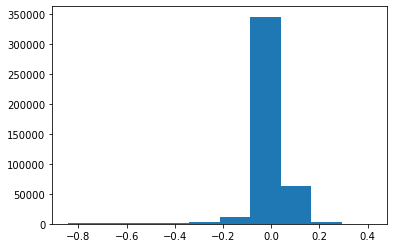

In [39]:
plt.hist(proj_id.numpy().flatten())

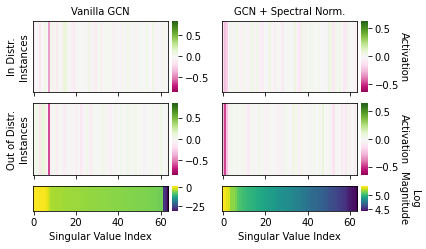

In [40]:
fig, axs = plt.subplots(3, 2, figsize=(6, 3.5), sharex=True, sharey=True, gridspec_kw = {
    'height_ratios' : [1, 1, 0.35], 'wspace' : 0.3, 'hspace' : .2
})


vmax = max(np.abs(proj_id).max(), np.abs(proj_ood).max())
vmin = -vmax

vmax_norm = max(np.abs(proj_id_norm).max(), np.abs(proj_ood_norm).max())
vmin_norm = -vmax_norm

# Upper row, id instances
im = axs[0, 0].imshow((proj_id.numpy()), aspect='auto', vmin=vmin, vmax=vmax, cmap='PiYG', interpolation='none')
# cbar = fig.colorbar(im, cax=axs[0, 1], ax=axs[0, 0], drawedges=False)
cbar = colorbar(im)# , label='Activation')

im = axs[0, 1].imshow((proj_id_norm.numpy()), aspect='auto', vmin=vmin_norm, vmax=vmax_norm, cmap='PiYG', interpolation='none')
cbar = colorbar(im, label='Activation')

# Lower row, ood instances
im = axs[1, 0].imshow((proj_ood.numpy()), aspect='auto', vmin=vmin, vmax=vmax, cmap='PiYG', interpolation='none')
cbar = colorbar(im) #, label='Activation')
im = axs[1, 1].imshow((proj_ood_norm.numpy()), aspect='auto', vmin=vmin_norm, vmax=vmax_norm, cmap='PiYG', interpolation='none')
cbar = colorbar(im, label='Activation')

# Spectrum

#vmin, vmax = min(log_svs[-1].min(), log_svs_norm[-1].min()), max(log_svs[-1].max(), log_svs_norm[-1].max())

axs[2, 0].set_ylim(0.0, .5)
im = axs[2, 0].imshow(np.log(svs['backbone.conv0.lin.weight'][-2]).reshape((1, -1)), aspect='auto', interpolation='none') #, vmin=vmin, vmax=vmax)
# remove_ticks(axs[2, 0])
#despine(axs[2, 0])
axs[2, 0].tick_params(axis='y', labelleft=False, left=False)
cbar = colorbar(im, label='')
# cbar.remove()


axs[2, 1].set_ylim(0.0, .5)
im = axs[2, 1].imshow(np.log(svs_norm['backbone.conv0.lin.weight'][-2]).reshape((1, -1)), aspect='auto', interpolation='none') #, vmin=vmin, vmax=vmax)
axs[2, 1].tick_params(axis='y', labelleft=False, left=False)
cbar = colorbar(im, label='Log\nMagnitude')
cbar.set_label('Log\nMagnitude', labelpad=29)
# cbar.remove()

for ax in axs.flatten():
    # despine(ax)
    ax.tick_params(axis='y', labelleft=False, left=False)
    
axs[0, 0].set_ylabel('In Distr.\nInstances')
axs[1, 0].set_ylabel('Out of Distr.\nInstances')
axs[2, 0].set_xlabel('Singular Value Index')
axs[2, 1].set_xlabel('Singular Value Index')
axs[0, 0].set_title('Vanilla GCN', fontsize=10)
axs[0, 1].set_title('GCN + Spectral Norm.', fontsize=10)
#axs[2, 0].set_title('Singular Value Log Magnitude', fontsize=10)
#axs[2, 1].set_title('Singular Value Log Magnitude', fontsize=10)

fig.savefig(f'thesis_nbs/spectral_activation_{dataset}.pdf', bbox_inches='tight')

In [41]:
proj_ood_norm

tensor([[-0.2372, -0.4549, -0.2071,  ...,  0.0103, -0.0602,  0.0294],
        [-0.1739, -0.4779, -0.2023,  ...,  0.0130, -0.0446, -0.0432],
        [-0.1971, -0.4545, -0.2552,  ..., -0.0042, -0.0239,  0.0271],
        ...,
        [-0.1513, -0.4590, -0.2364,  ...,  0.0216,  0.0135, -0.0016],
        [-0.2078, -0.4663, -0.2478,  ..., -0.0079,  0.0210,  0.0427],
        [-0.2050, -0.4077, -0.2699,  ...,  0.0464, -0.0047, -0.0222]])

In [42]:
svs_norm['backbone.conv0.lin.weight'][-2], svs['backbone.conv0.lin.weight'][-1]


(array([206.76422 , 204.00658 , 198.4637  , 196.00606 , 178.68895 ,
        177.16895 , 172.30688 , 163.61528 , 160.63264 , 158.5446  ,
        156.36229 , 155.23352 , 152.47124 , 151.41049 , 150.72792 ,
        149.55418 , 147.45473 , 146.68448 , 144.95068 , 143.34906 ,
        141.68797 , 140.8939  , 139.80183 , 138.75339 , 137.99059 ,
        135.96341 , 134.57791 , 133.3576  , 133.14662 , 131.98012 ,
        131.356   , 129.99199 , 129.63963 , 128.09927 , 126.64549 ,
        125.552666, 124.588   , 121.935   , 121.2125  , 120.07977 ,
        118.754135, 117.61177 , 115.726715, 115.131386, 114.75048 ,
        112.75966 , 112.484726, 112.39584 , 109.93639 , 109.2501  ,
        106.248   , 105.056335, 104.53087 , 102.78874 , 101.53673 ,
        100.20054 ,  98.93713 ,  98.211105,  96.16154 ,  92.72939 ,
         90.64734 ,  88.99543 ,  88.37083 ,  85.07843 ], dtype=float32),
 array([9.42558861e+00, 8.43988037e+00, 7.91220140e+00, 6.77355957e+00,
        6.41593599e+00, 5.67698002e+00,

In [43]:
u, s, v = np.linalg.svd(model_norm.backbone.convs[0].conv.lin.linear.weight.detach().cpu().numpy(), full_matrices=False)

In [44]:
s

array([206.54657 , 203.79182 , 198.25479 , 195.79973 , 178.50085 ,
       176.98245 , 172.1255  , 163.44304 , 160.46355 , 158.3777  ,
       156.1977  , 155.07011 , 152.31073 , 151.25111 , 150.56924 ,
       149.39674 , 147.2995  , 146.53008 , 144.7981  , 143.19817 ,
       141.53883 , 140.74559 , 139.65466 , 138.60732 , 137.84532 ,
       135.82028 , 134.43625 , 133.21722 , 133.00645 , 131.84119 ,
       131.21773 , 129.85515 , 129.50317 , 127.96443 , 126.51218 ,
       125.4205  , 124.45685 , 121.80664 , 121.08491 , 119.95337 ,
       118.62913 , 117.48797 , 115.60489 , 115.010185, 114.629684,
       112.64096 , 112.36632 , 112.27753 , 109.82066 , 109.13509 ,
       106.13616 , 104.94575 , 104.42083 , 102.68054 , 101.42985 ,
       100.09506 ,  98.83299 ,  98.10773 ,  96.06031 ,  92.63178 ,
        90.55192 ,  88.90175 ,  88.2778  ,  84.98887 ], dtype=float32)